In [1]:
import sys

sys.path.append("../../")

In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Objective
In this notebook, we will show how to evaluate the performance of a model on a test or validation set. 
This notebook assumes that the network has already been trained and saved.

# Input
1. data_dir: directory of the data. The datafile should be present in the data_dir.
2. ckpt_dir: directory of the checkpoint. The checkpoint file and config should be present in the ckpt_dir.

In [3]:
import random
import os
import numpy as np
import torch
import pickle
import ml_collections
import glob
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from tqdm import tqdm
import numpy as np
from disentangle.training import create_dataset, create_model
import matplotlib.pyplot as plt
from disentangle.core.loss_type import LossType
from disentangle.config_utils import load_config
from disentangle.analysis.lvae_utils import get_img_from_forward_output
from disentangle.analysis.plot_utils import clean_ax
from disentangle.core.data_type import DataType
from disentangle.core.psnr import PSNR
from disentangle.analysis.plot_utils import get_k_largest_indices, plot_imgs_from_idx
from disentangle.core.psnr import PSNR, RangeInvariantPsnr
from disentangle.core.data_split_type import DataSplitType
from disentangle.analysis.stitch_prediction import stitch_predictions
from disentangle.analysis.mmse_prediction import get_dset_predictions


torch.multiprocessing.set_sharing_strategy("file_system")

In [4]:
calibration_params_fpath = (
    None  # "./calibration_params_Val.pkl"  # the path from where one wants to load the calibration params
)

# data_dir = '/group/jug/ashesh/data/ventura_gigascience/'
# ckpt_dir = '/group/jug/ashesh/training/denoisplit/2503/D7-M3-S0-L0/1'

# paviaATN
# data_dir = "/group/jug/ashesh/data/microscopy"
# ckpt_dir = "/group/jug/ashesh/training/denoisplit/2503/D3-M3-S0-L0/1"

# BioSR
# ckpt_dir = "/group/jug/ashesh/training/denoisplit/2502/D16-M3-S0-L0/5"
# data_dir = "/group/jug/ashesh/data/BioSR/"

# HT-T24
# ckpt_dir = "/group/jug/ashesh/training/denoisplit/2502/D21-M3-S0-L0/9/"
# data_dir = "/group/jug/ashesh/data/scsplit_HT_T24/"

# HTLIF24
data_dir = "/group/jug/ashesh/data/scsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/"
ckpt_dir = "/group/jug/ashesh/training/disentangle/2505/D36-M3-S0-L8/3"

# ckpt_dir = "/home/ashesh.ashesh/paper_models/Hagen/MitoVsAct/LeanLC/"
# ckpt_dir = '/group/jug/ashesh/training_pre_eccv/disentangle/2211/D7-M3-S0-L0/1'

image_size_for_grid_centers = 256
custom_image_size = 512

MIXING_WEIGHT = 0.5
MAX_VAL = 1993  # This is just for HAGEN dataset !!!

batch_size = 4
num_workers = 4
use_deterministic_grid = None
threshold = None  # 0.02
compute_kl_loss = False
evaluate_train = False  # inspect training performance
eval_datasplit_type = DataSplitType.Test
val_repeat_factor = None
use_real_input = False

corr_pres_trans = True
# enable circular padded tranlation transform
enable_translation_transform = False
# we oscillate around the best t with a small delta
delta_t = 0.1
# homography transforms.
aug_theta_max = 0.0
aug_theta_z_max = 0
aug_shift_max = 0.0
enable_homography_transform = aug_theta_max > 0 or aug_theta_z_max > 0 or aug_shift_max > 0

# size of the block which is used to compute the correlation
elem_size = 10
mmse_count = 50
# error is computed from the first prediction
compute_error_from_first_prediction = True
k_forward_pass = 2
learn_noise_characteristics = True

k_prediction_mode = "entire"
# whether to enable the hflip, vflip and 90 degree rotation
with_transforms = False
# apply input transforms to input.
with_inp_transforms = True
keep_original_input_fraction = 0.0
# when disable stochasticity is set to True, we pick the modes from the latent space
# instead of sampling from the distributions. But note that this also means that we get suboptimal prediction as well. To fix this, one may want to have two models.
disable_stochasticity = False

# this ensure that while we fit to 50 percentile, we pick the best fit on the basis of multiple percentiles and so is more robust.
enable_percentile_evaluation = True
# number of pixels to skip from each border while computing the error and variance
skip_pixels_err_var_computation = None
background_quantile = 0.01


noise_est_stability_count = 20
noise_est_num_steps = 6000

notebook_output_fpath = None  # where this notebook will be saved.

In [5]:
# mmse_count = 5
# noise_est_stability_count = 1
# notebook_output_fpath = "."

In [6]:
if skip_pixels_err_var_computation is None:
    skip_pixels_err_var_computation = custom_image_size - image_size_for_grid_centers

In [7]:
def get_best_checkpoint(ckpt_dir):
    output = []
    for filename in glob.glob(ckpt_dir + "/*_best.ckpt"):
        output.append(filename)
    assert len(output) == 1, "\n".join(output)
    return output[0]

In [8]:
from disentangle.core.model_type import ModelType

config = load_config(ckpt_dir)
config = ml_collections.ConfigDict(config)
old_image_size = None
with config.unlocked():
    if "test_fraction" not in config.training:
        config.training.test_fraction = 0.0

    if "datadir" not in config:
        config.datadir = ""
    if "encoder" not in config.model:
        config.model.encoder = ml_collections.ConfigDict()
        assert "decoder" not in config.model
        config.model.decoder = ml_collections.ConfigDict()

        config.model.encoder.dropout = config.model.dropout
        config.model.decoder.dropout = config.model.dropout
        config.model.encoder.blocks_per_layer = config.model.blocks_per_layer
        config.model.decoder.blocks_per_layer = config.model.blocks_per_layer
        config.model.encoder.n_filters = config.model.n_filters
        config.model.decoder.n_filters = config.model.n_filters

    if "multiscale_retain_spatial_dims" not in config.model.decoder:
        config.model.decoder.multiscale_retain_spatial_dims = False

    if "res_block_kernel" not in config.model.encoder:
        config.model.encoder.res_block_kernel = 3
        assert "res_block_kernel" not in config.model.decoder
        config.model.decoder.res_block_kernel = 3

    if "res_block_skip_padding" not in config.model.encoder:
        config.model.encoder.res_block_skip_padding = False
        assert "res_block_skip_padding" not in config.model.decoder
        config.model.decoder.res_block_skip_padding = False

    if config.data.data_type == DataType.CustomSinosoid:
        if "max_vshift_factor" not in config.data:
            config.data.max_vshift_factor = config.data.max_shift_factor
            config.data.max_hshift_factor = 0
        if "encourage_non_overlap_single_channel" not in config.data:
            config.data.encourage_non_overlap_single_channel = False

    if "skip_bottom_layers_count" in config.model:
        config.model.skip_bottom_layers_count = 0

    if "logvar_lowerbound" not in config.model:
        config.model.logvar_lowerbound = None
    if "train_aug_rotate" not in config.data:
        config.data.train_aug_rotate = False
    if "multiscale_lowres_separate_branch" not in config.model:
        config.model.multiscale_lowres_separate_branch = False
    if "multiscale_retain_spatial_dims" not in config.model:
        config.model.multiscale_retain_spatial_dims = False
    config.data.train_aug_rotate = False

    if "randomized_channels" not in config.data:
        config.data.randomized_channels = False

    if "predict_logvar" not in config.model:
        config.model.predict_logvar = None

    if "batchnorm" in config.model and "batchnorm" not in config.model.encoder:
        assert "batchnorm" not in config.model.decoder
        config.model.decoder.batchnorm = config.model.batchnorm
        config.model.encoder.batchnorm = config.model.batchnorm
    if "conv2d_bias" not in config.model.decoder:
        config.model.decoder.conv2d_bias = True

    if custom_image_size is not None:
        old_image_size = config.data.image_size
        config.data.image_size = custom_image_size
    if image_size_for_grid_centers is not None:
        old_grid_size = config.data.get("grid_size", "grid_size not present")
        config.data.grid_size = image_size_for_grid_centers
        config.data.val_grid_size = image_size_for_grid_centers

    if use_deterministic_grid is not None:
        config.data.deterministic_grid = use_deterministic_grid
    if threshold is not None:
        config.data.threshold = threshold
    if val_repeat_factor is not None:
        config.training.val_repeat_factor = val_repeat_factor
    config.model.mode_pred = not compute_kl_loss

    config.model.skip_nboundary_pixels_from_loss = None
    if config.model.model_type == ModelType.UNet and "n_levels" not in config.model:
        config.model.n_levels = 4

    if config.model.model_type == ModelType.UNet and "init_channel_count" not in config.model:
        config.model.init_channel_count = 64

    if "skip_receptive_field_loss_tokens" not in config.loss:
        config.loss.skip_receptive_field_loss_tokens = []

    if "lowres_merge_type" not in config.model.encoder:
        config.model.encoder.lowres_merge_type = 0

if use_real_input:
    # NOTE: FIX FOR 2-CHANNEL SPLITTING TASK.
    with config.unlocked():
        config.data.input_idx = 2
        config.data.keep_real_input = True
print(config)

data:
  channelwise_quantile: false
  clip_percentile: 1
  data_type: 36
  deterministic_grid: false
  enable_gaussian_noise: false
  grid_size: 256
  image_size: 512
  input_has_dependant_noise: true
  input_is_sum: false
  multiscale_lowres_count: 3
  normalized_input: true
  padding_mode: reflect
  padding_value: null
  poisson_noise_factor: -1
  randomized_channels: false
  sampler_type: 0
  synthetic_gaussian_scale: 100
  target_separate_normalization: true
  threshold: 0.02
  train_aug_rotate: false
  use_one_mu_std: true
  val_grid_size: 256
datadir: /group/jug/ashesh/data/diffsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/
exptname: 2505/D36-M3-S0-L8/3
git:
  branch: indiSplit_baselines
  changedFiles: []
  latest_commit: 7e26c0824c5753e75463718f33f08244ad261cec
  untracked_files: []
hostname: gnode07
loss:
  denoisplit_w: 0.9
  free_bits: 1.0
  kl_annealing: false
  kl_annealtime: 10
  kl_loss_formulation: denoisplit_usplit
  kl_min: 1.0e-07
  kl_start: -1
  kl_weight: 1.0
  loss_type: 8


In [9]:
# since we are doing the clipping in the other way.
config.data.clip_percentile = 1

## Loading the dataset

In [ ]:
from disentangle.data_loader.vanilla_dloader import MultiChDloader
from disentangle.data_loader.lc_multich_dloader import LCMultiChDloader
from disentangle.core.data_split_type import DataSplitType
from disentangle.data_loader.patch_index_manager import TilingMode


class TiffDloaderMixed(MultiChDloader):
    """
    Now, we have just the inputs, and no targets.
    """

    def load_data(self, data_config, datasplit_type, val_fraction=None, test_fraction=None, allow_generation=None):
        super().load_data(
            data_config,
            datasplit_type,
            val_fraction=val_fraction,
            test_fraction=test_fraction,
            allow_generation=allow_generation,
        )
        self._data_original = self._data
        new_data = self._data.copy()
        assert np.abs(new_data - new_data.astype(np.uint32)).max() == 0, "Data is not of integer type"

        if config.data.data_type == DataType.SeparateTiffData:
            print("Clipping the data to 1993")
            new_data[new_data > MAX_VAL] = MAX_VAL
        if self._input_idx is None:
            new_channel = new_data[..., 0:1] * MIXING_WEIGHT + new_data[..., 1:2] * (1 - MIXING_WEIGHT)
            self._data = np.concatenate(
                [new_data.astype(np.uint32), new_channel.astype(np.uint32)], axis=-1, dtype=np.uint32
            )
            self._input_idx = self._data.shape[-1] - 1
            self._num_channels = self._data.shape[-1]
        else:
            assert self._data.shape[-1] >= 3, "Expected at least 3 channels in the data."
            self._data = new_data
            self._num_channels = self._data.shape[-1]
        # self._data[self._data > MAX_VAL] = MAX_VAL


class MultiScaleTiffDloaderMixed(LCMultiChDloader):
    """
    Now, we have just the inputs, and no targets.
    """

    def load_data(self, data_config, datasplit_type, val_fraction=None, test_fraction=None, allow_generation=None):
        super().load_data(
            data_config,
            datasplit_type,
            val_fraction=val_fraction,
            test_fraction=test_fraction,
            allow_generation=allow_generation,
        )
        self._data_original = self._data
        new_data = self._data.copy()
        intdtype = np.abs(new_data - new_data.astype(np.uint32)).max() == 0
        if config.data.data_type == DataType.SeparateTiffData:
            print("Clipping the data to 1993")
            new_data[new_data > MAX_VAL] = MAX_VAL

        if self._input_idx is None:
            new_channel = new_data[..., 0:1] * MIXING_WEIGHT + new_data[..., 1:2] * (1 - MIXING_WEIGHT)
            self._data = np.concatenate(
                [new_data.astype(np.uint32), new_channel.astype(np.uint32)],
                axis=-1,
                dtype=np.uint32 if intdtype else None,
            )
            self._input_idx = self._data.shape[-1] - 1
            self._num_channels = self._data.shape[-1]
        else:
            assert self._data.shape[-1] >= 3, "Expected at least 3 channels in the data."
            self._data = new_data
            self._num_channels = self._data.shape[-1]
        # self._data[self._data > MAX_VAL] = MAX_VAL


padding_kwargs = {
    "mode": config.data.get("padding_mode", "constant"),
}

if padding_kwargs["mode"] == "constant":
    padding_kwargs["constant_values"] = config.data.get("padding_value", 0)

dloader_kwargs = {"overlapping_padding_kwargs": padding_kwargs}
if "multiscale_lowres_count" in config.data and config.data.multiscale_lowres_count is not None:
    data_class = MultiScaleTiffDloaderMixed
    dloader_kwargs["num_scales"] = config.data.multiscale_lowres_count
    dloader_kwargs["padding_kwargs"] = padding_kwargs
else:
    # raise Exception('Not implemented')
    data_class = TiffDloaderMixed

if config.data.data_type in [
    DataType.CustomSinosoid,
    DataType.CustomSinosoidThreeCurve,
    DataType.SeparateTiffData,
    DataType.indiSplit_HTLIF24,
    DataType.BioSR_MRC,
    DataType.TavernaSox2GolgiV2,
]:
    datapath = data_dir
elif config.data.data_type == DataType.OptiMEM100_014:
    datapath = os.path.join(data_dir, "OptiMEM100x014.tif")
else:
    raise NotImplementedError(config.data.data_type)

normalized_input = config.data.normalized_input
use_one_mu_std = config.data.use_one_mu_std
train_aug_rotate = config.data.train_aug_rotate
enable_random_cropping = False
tiling_mode = TilingMode.ShiftBoundary
print(data_class)

train_dset = data_class(
    config.data,
    datapath,
    datasplit_type=DataSplitType.Train,
    val_fraction=config.training.val_fraction,
    test_fraction=config.training.test_fraction,
    normalized_input=normalized_input,
    use_one_mu_std=use_one_mu_std,
    enable_rotation_aug=train_aug_rotate,
    enable_random_cropping=enable_random_cropping,
    tiling_mode=tiling_mode,
    **dloader_kwargs,
)
import gc

gc.collect()
max_val = train_dset.get_max_val()

val_dset = data_class(
    config.data,
    datapath,
    datasplit_type=eval_datasplit_type,
    val_fraction=config.training.val_fraction,
    test_fraction=config.training.test_fraction,
    normalized_input=normalized_input,
    use_one_mu_std=use_one_mu_std,
    enable_rotation_aug=False,  # No rotation aug on validation
    enable_random_cropping=False,
    # No random cropping on validation. Validation is evaluated on determistic grids
    tiling_mode=tiling_mode,
    max_val=max_val,
    **dloader_kwargs,
)

# For normalizing, we should be using the training data's mean and std.
mean_val, std_val = train_dset.compute_mean_std()
train_dset.set_mean_std(mean_val, std_val)
val_dset.set_mean_std(mean_val, std_val)


if evaluate_train:
    val_dset = train_dset
data_mean, data_std = train_dset.get_mean_std()


<class '__main__.MultiScaleTiffDloaderMixed'>


/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')


Loaded indiSplit_HTLIF24 data from /group/jug/ashesh/data/scsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/train/train_500ms_Ch_B-Ch_D-Ch_BD.tif (90, 1608, 1608, 2)

Padding is not used with this alignement style
[MultiScaleTiffDloaderMixed] Train:1 Sz:5123240 DimSz:(90,6,6,1) TrimB:2 Rot:False RandCrop:False Channel:3 Pad:{'mode': 'reflect'}


/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')


Loaded indiSplit_HTLIF24 data from /group/jug/ashesh/data/scsplit_HT_LIF/500ms/Ch_B-Ch_D-Ch_BD/test/test_500ms_Ch_B-Ch_D-Ch_BD.tif (10, 1608, 1608, 2)

Padding is not used with this alignement style
[MultiScaleTiffDloaderMixed] Train:0 Sz:512360 DimSz:(10,6,6,1) TrimB:2 Rot:False RandCrop:False Channel:3 Pad:{'mode': 'reflect'}


AssertionError: tar_idx_list must be set if input_idx is set.

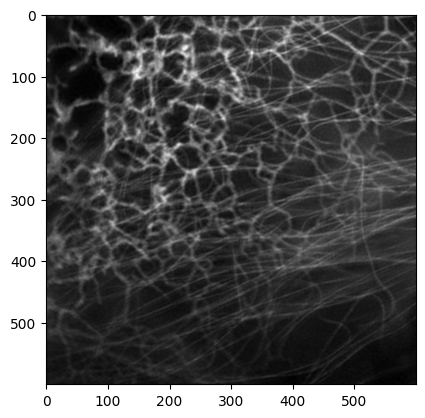

In [11]:
plt.imshow(val_dset._data[0, -600:, :600, 2], cmap="gray")

## Loading the model

In [12]:
with config.unlocked():
    if old_image_size is not None:
        config.data.image_size = old_image_size
    # if 'input_is_sum' not in config.data:
    #     config.data.input_is_sum = False

if config.data.target_separate_normalization is True:
    mean_fr_model, std_fr_model = train_dset.compute_individual_mean_std()
    # removing the synthetic input channel.
    mean_fr_model = mean_fr_model[:, :-1]
    std_fr_model = std_fr_model[:, :-1]

else:
    mean_fr_model, std_fr_model = train_dset.get_mean_std()


model = create_model(config, {"target": mean_fr_model}, {"target": std_fr_model})

ckpt_fpath = get_best_checkpoint(ckpt_dir)
checkpoint = torch.load(ckpt_fpath)

_ = model.load_state_dict(checkpoint["state_dict"])
model.eval()
_ = model.cuda()

model.set_params_to_same_device_as(torch.Tensor(1).cuda())

print("Loading from epoch", checkpoint["epoch"])

Noise model Ch1: /group/jug/ashesh/training/noise_model/2502/5/GMMNoiseModel_ER-GT_all__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
Noise model Ch2: /group/jug/ashesh/training/noise_model/2502/6/GMMNoiseModel_Microtubules-GT_all__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[LadderVAE] Stoc:True RecMode:False TethInput:False
Loading from epoch 366


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model has {count_parameters(model) / 1000_000:.3f}M parameters")

Model has 3.249M parameters


In [14]:
if config.data.multiscale_lowres_count is not None and custom_image_size is not None:
    model.reset_for_different_output_size(custom_image_size)

## Mean/Std as present in usplit. Just run Evaluate.ipynb for this config and set it here
Note that for indiSplit, our usecase is that input can have differet mean/std than the training data. So, we just use the mean/std computed on the input data now. the commented code is for the case when we want to use the mean/std of the training data, which yields better performance.

In [15]:
# if config.data.data_type == DataType.SeparateTiffData:
#     mean_val_usplit = np.array([[[[237.37582]],[[237.37582]]]])
#     std_val_usplit = np.array([[[[299.02316]],[[299.02316]]]])
# elif config.data.data_type in [DataType.HTLIF24, DataType.BioSR_MRC, DataType.TavernaSox2GolgiV2]:
#     mean_val_usplit, std_val_usplit = train_dset.get_mean_std()
# else:
#     raise NotImplementedError(config.data.data_type)
mean_val_usplit, std_val_usplit = train_dset.get_mean_std()
val_dset.set_mean_std(mean_val_usplit, std_val_usplit)

## Looking at the input

Text(0, 0.5, 'Target')

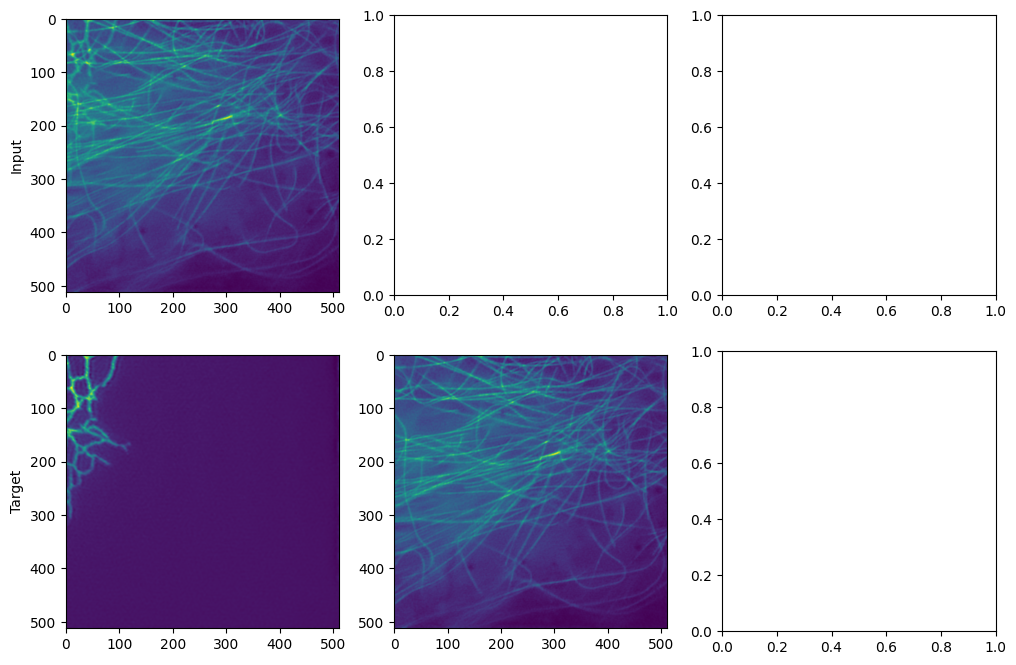

In [16]:
idx = np.random.randint(len(val_dset))
inp_tmp, tar_tmp, *_ = val_dset[idx]
if inp_tmp.ndim == 2:
    inp_tmp = inp_tmp[None, ...]

ncols = max(len(inp_tmp), 3)
nrows = 2
_, ax = plt.subplots(figsize=(4 * ncols, 4 * nrows), ncols=ncols, nrows=nrows)
for i in range(len(inp_tmp)):
    ax[0, i].imshow(inp_tmp[i])


ax[1, 0].imshow(tar_tmp[0])
ax[1, 1].imshow(tar_tmp[1])

ax[0, 0].set_ylabel("Input")
ax[1, 0].set_ylabel("Target")

In [17]:
import torch.nn as nn


class NnModel(nn.Module):
    def __init__(self, model):
        super(NnModel, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)[0]

    def normalize_target(self, x):
        return self.model.normalize_target(x)


singleoutput_model = NnModel(model).cuda()

In [18]:
# uq_processor.quantify()
from finetunesplit.posterior_sampler import PosteriorSampler
from finetunesplit.calibration.find_optimal_parameters import find_optimal_params
from finetunesplit.calibration.grid_search import plot_coverage_plot
from finetunesplit.uq_quantification import UncertaintyQuantification

uq_processor = UncertaintyQuantification(
    singleoutput_model,
    train_dset,
    val_dset,
    metric_func_for_mixingratio=RangeInvariantPsnr,
    stitch_function=stitch_predictions,
    tqdm_disable=False,
)
plot = False
homography_transform_params = None
if enable_homography_transform:
    homography_transform_params = {
        "theta_max": aug_theta_max,
        "theta_z_max": aug_theta_z_max,
        "shift_max": aug_shift_max,
        "device": "cuda",
    }
    print("Enabling homography transform", homography_transform_params)

transforms_config = {
    "correlation_preserving_transforms": corr_pres_trans,
    "with_pred_transforms": with_transforms,
    "with_inp_transforms": with_inp_transforms,
    "enable_translation_transform": enable_translation_transform,
    "homography_transform_params": homography_transform_params,
    "enable_percentile_evaluation": enable_percentile_evaluation,
}
err_and_var_config = {
    "percentiles_to_evaluate": [10, 20, 30, 40, 50, 60, 70, 80, 90],
    "skip_pixels": skip_pixels_err_var_computation,
    "elem_size": elem_size,
    "compute_error_from_first_prediction": compute_error_from_first_prediction,
}


pred_dict = uq_processor.get_input_tar_pred(
    uq_processor._val, uq_processor.model, batch_size=batch_size, mmse_count=mmse_count, num_workers=num_workers
)

# get optimal mixing ratio from input and predictions
mixing_t_pred = uq_processor.optimal_mixing_ratio(pred_dict["inp"], pred_dict["pred"])
print("Obtained optimal mixing t from predictions:", mixing_t_pred)

# get estimated input patches
estimated_inp_patches = uq_processor.get_estimated_inp(pred_dict["pred"], mixing_t_pred)
normalized_inp_patches = pred_dict["inp"]

# use estimated input patches to learn noise parameters
noise_params = uq_processor.estimate_input_noise_params(
    normalized_inp_patches,
    estimated_inp_patches,
    stability_count=noise_est_stability_count,
    num_steps=noise_est_num_steps,
    plot=plot,
)

# now, we have the forward operator parameters
forward_operator_params = uq_processor.get_forward_operator_params(mixing_t_pred, delta_t, noise_params)

# get transforms
transform_dict = uq_processor.get_transforms(
    correlation_preserving_transforms=transforms_config["correlation_preserving_transforms"],
    with_pred_transforms=transforms_config["with_pred_transforms"],
    with_inp_transforms=transforms_config["with_inp_transforms"],
    enable_translation_transform=transforms_config["enable_translation_transform"],
    homography_transform_params=transforms_config["homography_transform_params"],
    enable_percentile_evaluation=transforms_config["enable_percentile_evaluation"],
)

# instantiate the sampler
psampler = PosteriorSampler(
    uq_processor.model,
    transform_dict["pred_transform"],
    forward_operator_params=forward_operator_params,
    mmse_count=mmse_count,
    k_forward_pass=k_forward_pass,
    input_transforms=transform_dict["inp_transform"],
    keep_original_input_fraction=keep_original_input_fraction,
)

_ = uq_processor.test_sampler(psampler, plot=plot)

# now, get err and var
err, var, pred_b, one_step_pred_mmse = uq_processor.get_err_and_var(
    uq_processor.model, psampler, batch_size=batch_size, num_workers=num_workers, uq_params=err_and_var_config
)
if plot:
    uq_processor.plot_err_var(pred_b, one_step_pred_mmse, var, err)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 28.63it/s]


Best t value: 0.52
Obtained optimal mixing t from predictions: 0.52


loss: 0.010, alpha_dyn: 1.024, beta_dyn: -0.011, sigma_dyn: 0.018, std_loss: 0.001 poisson_loss: 15.218 alpha_poisson: 1.004 beta_poisson: -0.000: 100%|██████████| 6000/6000 [03:38<00:00, 27.41it/s]  


Learned parameters: alpha, beta, sigma 1.0243104696273804 -0.010793378576636314 0.01792016252875328 1.004028558731079 -0.00014283436757978052
Transforms for Ch1: [('identity', {})]
Transforms for Ch2: [('identity', {})]
Using correlation preserving transforms
Using transform types: {0: [Identity(transform_type='identity')], 1: [Identity(transform_type='identity')]}


Transforms for Ch1: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Transforms for Ch2: [('rotate', {}), ('hflip', {}), ('vflip', {})]
Using correlation preserving transforms
Using transform types: {0: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')], 1: [Rotate(transform_type='rotate'), HFlip(transform_type='hflip'), VFlip(transform_type='vflip')]}
[PosteriorSampler] k_forward_pass: 2
[PosteriorSampler] mixing_t range: [0.42000000000000004, 0.62], mu: -0.010793378576636314, sigma: 1.0243104696273804, gaussian_noise_std: 0.01792016252875328
[PosteriorSampler] Input transforms e

100%|██████████| 12/12 [00:18<00:00,  1.55s/it]


In [ ]:
if calibration_params_fpath is not None:
    import pickle

    print("Loading calibration params from", calibration_params_fpath)
    with open(calibration_params_fpath, "rb") as f:
        calibration_params = pickle.load(f)
    factors_shifted = calibration_params["factors_shifted"]
    offsets_shifted = calibration_params["offsets_shifted"]
    q_var = calibration_params["q_var"]
    q_err = calibration_params["q_err"]
    achieved_percentiles = calibration_params["achieved_percentiles"]
    assert notebook_output_fpath is None, (
        "One does not need to save the notebook output when loading calibration params"
    )
else:
    output, metadata = find_optimal_params(
        err,
        var,
        percentiles_to_evaluate=err_and_var_config["percentiles_to_evaluate"],
        q_bkg=background_quantile,
        around_center=False,
    )
    factors_shifted, offsets_shifted = output
    print("Optimal factors:", factors_shifted)
    print("Optimal offsets:", offsets_shifted)
    q_var = metadata["q_var"]
    q_err = metadata["q_err"]
    achieved_percentiles = metadata["achieved_percentiles"]

In [ ]:
import pickle

calibration_params = {
    "q_var": np.array(q_var).tolist(),
    "q_err": np.array(q_err).tolist(),
    "achieved_percentiles": np.array(achieved_percentiles).tolist(),
    "factors_shifted": factors_shifted,
    "offsets_shifted": offsets_shifted,
    "mmse_count": mmse_count,
}
for key, val in calibration_params.items():
    print(f"{key}: {val}")

if notebook_output_fpath is not None:
    print(f"Saving calibration params to {notebook_output_fpath}")
    with open(notebook_output_fpath, "wb") as f:
        pickle.dump(calibration_params, f)

q_var: [0.00024349798331968486, 0.0008447333239018917]
q_err: [0.00027870191843248904, 0.00041919801151379943]
achieved_percentiles: [49.5862904621776, 49.76134477033758]
factors_shifted: [4.375, 2.1875]
offsets_shifted: [0.0, 0.0]
mmse_count: 5


LeftOriented: Channel 0 MAE 11.10, MAX Err 26.79
LeftOriented: Channel 1 MAE 8.79, MAX Err 24.31


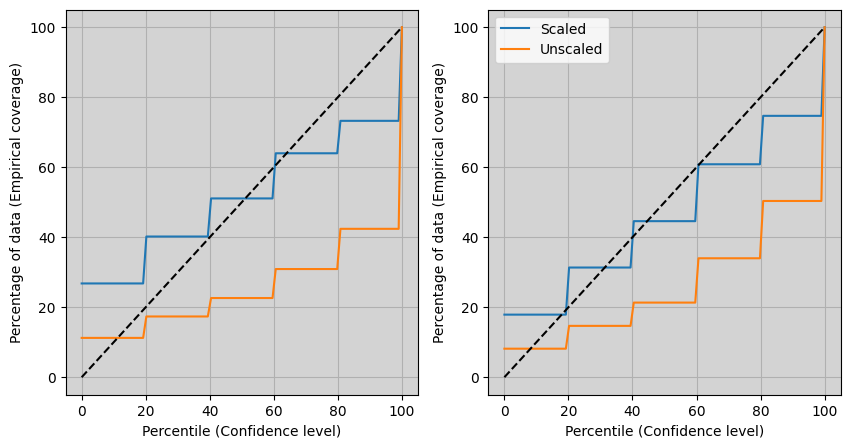

In [21]:
data_left_oriented = plot_coverage_plot(
    var - np.array(q_var)[None, :, None],
    err,
    factors_shifted,
    [k + q_err[i] for i, k in enumerate(offsets_shifted)],
    around_center=False,
)

perfect = np.linspace(0, 100, 100)
mean_err_arr = []
max_err_arr = []
for col_idx in range(var.shape[1]):
    act = data_left_oriented[col_idx]["scaled"][1]
    mean_err = np.abs(perfect - act).mean()
    max_err = np.abs(perfect - act).max()
    mean_err_arr.append(mean_err)
    max_err_arr.append(max_err)
    print(f"LeftOriented: Channel {col_idx} MAE {mean_err:.2f}, MAX Err {max_err:.2f}")


In [ ]:
from disentangle.core.metrics import compute_stats

pred = stitch_predictions(pred_dict["pred"], val_dset)


def print_ignored_pixels():
    ignored_pixels = 1
    while (
        pred[
            0,
            -ignored_pixels:,
            -ignored_pixels:,
        ].std()
        == 0
    ):
        ignored_pixels += 1
    ignored_pixels -= 1
    print(f"In {pred.shape}, last {ignored_pixels} many rows and columns are all zero.")
    return ignored_pixels


ignored_pixels_in_data = print_ignored_pixels()
assert ignored_pixels_in_data == 0, "We do not expect any ignored pixels here."

tar = val_dset._data_original


sep_mean, sep_std = model.data_mean, model.data_std
if isinstance(sep_mean, dict):
    sep_mean = sep_mean["target"]
    sep_std = sep_std["target"]

sep_mean = sep_mean.squeeze()[None, None, None]
sep_std = sep_std.squeeze()[None, None, None]
pred_unnormalized = pred * sep_std.cpu().numpy() + sep_mean.cpu().numpy()
stats_dict = compute_stats(tar, pred_unnormalized)
print(
    f"W:{MIXING_WEIGHT} {DataSplitType.name(eval_datasplit_type)}_P{custom_image_size}_G{image_size_for_grid_centers}_M{mmse_count}_Sk{ignored_pixels_in_data}"
)


In (5, 1004, 1004, 2), last 0 many rows and columns are all zero.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/localscratch/code/Disentangle/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localscratch/code/Disentangle/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /localscratch/code/Disentangle/.venv/lib/python3.13/site-packages/lpips/weights/v0.1/alex.pth


100%|██████████| 5/5 [00:00<00:00, 29.97it/s]
/localscratch/code/MicroSSIM/src/microssim/ssim/ssim_utils.py:297: RuntimeWarning: invalid value encountered in sqrt
  term = 2 * alpha * np.sqrt(elements.vx * elements.vy) + elements.C2
100%|██████████| 5/5 [00:00<00:00, 29.79it/s]


PSNR:	 33.2+-0.215	33.35+-0.209
MicroSSIM:	 0.845+-0.062	0.900+-0.007
MicroS3IM:	 0.959+-0.008	0.960+-0.004
SSIM:	 0.750+-0.076	0.874+-0.021
MSSSIM:	 0.931+-0.013	0.942+-0.004
lpips:	 0.078+-0.009	0.087+-0.011
W:0.5 Test_P512_G256_M5_Sk0
